# 2. 없다면 어떻게 될까? (ResNet Ablation Study)

**핵심적인 기법들을 하나씩 제거했을 때의 효과를 각각 정량적으로 측정하는 ablation study 기법을 배운다. ResNet을 대상으로 실습해 보면서 이론적으로 익힌 기법의 효과를 체감하고 백본을 직접 다뤄보는 실전적 감각을 익힌다.**

## 2-7. 프로젝트: ResNet Ablation Study

---

## 목차
- 0) 라이브러리 버전 확인하기
- 1) ResNet 기본 블록 구성하기
- 2) ResNet-34, ResNet-50 Complete Model
- 3) 일반 네트워크(plain network) 만들기
- 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

---

### 라이브러리 임포트 및 확인

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import urllib3
urllib3.disable_warnings()

In [2]:
print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


### GPU 확인

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 상수 설정
- BATCH_SIZE 가 클수록 훈련 시간 단축, 1 EPOCH 당 1분 이상 소요됨
- 데이터셋 CIFAR-10 의 경우 40 EPOCHS 정도 수행하는 것을 권장, 15 EPOCHS 정도로도 근접한 성능 얻을 수 있음
- batch_size 와 learning_rate 최고의 조합 찾기 [[참고]](https://inhovation97.tistory.com/32)
    - Best
        - 작은 batch, 낮은 lr (e.g. 16, 0.0001)
        - 큰 batch, 높은 lr (e.g. 256, 0.001)
    - Worst
        - 작은 batch, 높은 lr (e.g. 16, 0.001)
        - 큰 batch, 낮은 lr (e.g. 256, 0.0001)

In [4]:
BATCH_SIZE = 64  # 256
EPOCHS = 15  # 15
LR = 0.1
OPT_DECAY = 0.0001
MOMENTUM = 0.9
L2_WEIGHT_DECAY = 1e-4
BATCH_NORM_DECAY = 0.9
BATCH_NORM_EPSILON = 1e-5

ACTIVATION = 'sigmoid'
NUM_CLASSES = 1

### 데이터 가져와서 확인
- ds_info = tfds.load(): 기본적으로 ~/tensorflow_datasets 경로에 데이터셋 다운로드
- Tensorflow의 데이터셋은 Numpy가 아님 => 다른 방법으로 정보 확인해야 함!
    - ds_info.features  # feature 정보 확인
    - tf.data.experimental.cardinality(ds_train)  # 데이터셋의 이미지 shape와 전체 데이터의 개수, 라벨 클래스의 개수 확인

- 데이터셋 다운로드
    - tfds.load()

In [5]:
# tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

- 데이터셋 features 확인
    - ds_info: 데이터셋의 메타 정보

In [6]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


- 데이터셋 개수 확인
    - Tensorflow 데이터셋은 Numpy 가 아님 => ds_train.shape 사용 불가
    - tf.data.experimental.cardinality(ds_train) 로 확인

In [7]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))  # tf.Tensor(18610, shape=(), dtype=int64)
print(tf.data.experimental.cardinality(ds_test))  # tf.Tensor(4652, shape=(), dtype=int64)

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


- 데이터셋 클래스 개수 및 구성 확인

In [8]:
ds_info.features["label"].num_classes  # 2

2

In [9]:
ds_info.features["label"].names  # ['cat', 'dog']

['cat', 'dog']

- 각 이미지 클래스와 인덱스 확인
    - 학습용 데이터셋 확인
    - 평가용 데이터셋 확인

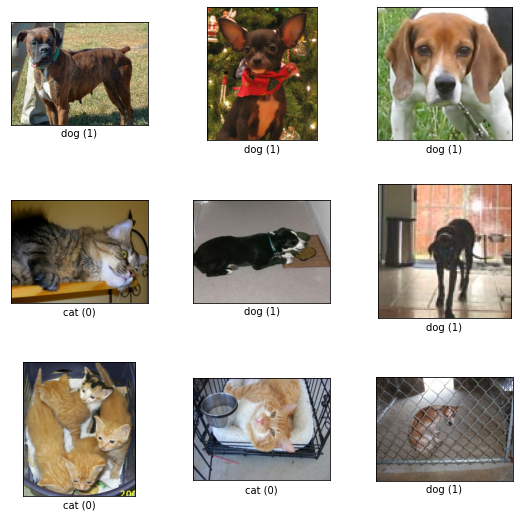

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

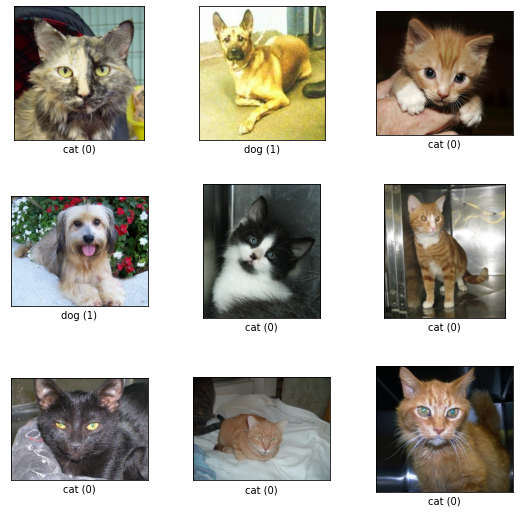

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

### Input Normalization
- Data Normalization: 데이터의 범위를 사용자가 원하는 범위로 제한하는 것
    - 이미지 데이터의 경우 픽셀 정보를 0~255 사이의 값으로 가지는데, 이를 255로 나누어주면 [0, 1] 사이의 값을 가짐
    - f(x) = $\frac{x-x_{min}}{x_{max}-x_{min}}$
    - 사용 이유
        - 머신러닝에서 scale이 큰 feature의 영향이 비대해지는 것을 방지
        - 딥러닝에서 Local optimum에 빠질 위험을 줄임(학습 속도 향상)
    - scikit-learn에서 MinMaxScaler로 쉽게 사용
- 모델에 넣어주기 전에 각 채널별 최댓값인 255로 정규화(normalize)

- 데이터 전처리
    - 학습 데이터와 검증 데이터에 normalizing 과 resizing 적용

In [12]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

- 전처리 포함한 배치 구성

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

- 데이터셋에 전처리와 배치 처리 적용

In [14]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

- 구성된 배치 모양 확인

In [15]:
for input in ds_train.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(64, 224, 224, 3)
(64,)


### ResNet, Plain 구현

- 블록을 단위로 모델을 만들 수 있어야 함!
    - 블록(block): 일반적인 딥러닝 모델에서 이렇게 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위
    - 레이어(layer): 기본적으로 텐서플로우(TensorFlow), 케라스(Keras), 파이토치(PyTorch) 등에서 기본적으로 제공하는 단위
- ResNet
    - ResNet-18, 34, 50, 101, 152<br>![](https://d3s0tskafalll9.cloudfront.net/media/images/resnet.max-800x600.png)
- Plain: ResNet 에서 Residual Block 이 없는 형태
    - ResNet-34, Plain-34<br>![](https://d3s0tskafalll9.cloudfront.net/media/images/F-22-14.max-800x600.png)

#### 블록 생성 함수

In [16]:
def conv_block(input_layer, 
                channel, 
                kernel_size, 
                strides=1, 
                activation='relu',
                l2_weight_decay=1e-4,
                batch_norm_decay=0.9,
                batch_norm_epsilon=1e-5):
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=kernel_size,
        kernel_initializer='he_normal',
        kernel_regularizer=keras.regularizers.l2(l2_weight_decay),
        padding='same',
        strides=strides,
        use_bias=False,
    )(input_layer)
    
    x = keras.layers.BatchNormalization(
        # momentum=batch_norm_decay,
        # epsilon=batch_norm_epsilon,
    )(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [17]:
def build_net_block(input_layer, 
                    cnn_count=3, 
                    channel=64, 
                    block_num=0, 
                    is_50=True,
                    is_ResNet=True):

    x = input_layer
    
    # 첫 번째 conv_layer 에서 strides=2 설정해서 너비와 높이를 줄임
    # => 필터의 개수(=채널)가 증가할 때마다 너비와 높이를 줄임

    # ResNet-50, Plain-50
    if is_50:
        if is_ResNet: # ResNet-50
            for i in range(cnn_count):
                if i == 0:
                    shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-50
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
                else:
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
    # ResNet-34, Plain-34
    else:
        if is_ResNet:  # ResNet-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3))
                else:
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3))

    return x

#### 모델 생성 함수

In [18]:
def build_net(input_shape=(32,32,3),
                cnn_count_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=10, 
                is_50=True,
                is_ResNet=True,
                activation='softmax',
                name='ResNet_50'):
    
    # 모델 생성 전, config list들이 같은 길이인지 확인
    assert len(cnn_count_list) == len(channel_list)
    
    # input layer 생성
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer 설정
    x = conv_block(input_layer, 64, (7,7), strides=2)
    # x = keras.layers.MaxPool2D(pool_size=(3,3), strides=2)(x)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서
    # - is_ResNet=True 일 경우, Residual block 블록을 생성합니다.
    # - is_ResNet=False 일 경우, Plain block 블록을 생성합니다.
    for block_num, (cnn_count, channel) in enumerate(zip(cnn_count_list, channel_list)):
        x = build_net_block(x, 
                            cnn_count=cnn_count, 
                            channel=channel, 
                            block_num=block_num, 
                            is_50=is_50,
                            is_ResNet=is_ResNet)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                        activation=activation, 
                        kernel_initializer='he_normal'
                        )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

#### 모델 생성 및 확인

- ResNet-34, ResNet-50 생성

In [19]:
resnet_34 = build_net(
    input_shape=(224,224,3),
    is_50=False,
    is_ResNet=True,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='ResNet_34',
)
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

In [20]:
resnet_50 = build_net(
    input_shape=(224,224,3),
    is_50=True,
    is_ResNet=True,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='ResNet_50',
)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 112, 112, 64  9408        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 112, 112, 64  256        ['conv2d_36[0][0]']              
 ormalization)                  )                                                         

- Plain-34, Plain-50 생성

In [21]:
plain_34 = build_net(
    input_shape=(224,224,3),
    is_50=False,
    is_ResNet=False,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='Plain_34',
)
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_89 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_90 (Conv2D)          (None, 56, 56, 64)        368

In [22]:
plain_50 = build_net(
    input_shape=(224,224,3),
    is_50=True,
    is_ResNet=False,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='Plain_50',
)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_122 (Conv2D)         (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_122 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_123 (Conv2D)         (None, 56, 56, 64)        409

### ResNet vs Plain 비교

#### 학습

- 모델 학습 함수
    - 데이터셋이 작을 경우, Adam 보다 SGD 가 더 학습에 유리하다.

In [23]:
def comile_and_fit(model, ds_train, ds_test, ds_info, learning_rate=0.01, momentum= 0.9, opt_decay=0.0001, batch_size=128, epochs=15):
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.SGD(
            learning_rate=learning_rate,
            # momentum=momentum,
            # decay=opt_decay,
            clipnorm=1.
        ),
        metrics=['accuracy'],
    )

    history = model.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['train[80%:]'].num_examples/batch_size),
        epochs=epochs,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history

- ResNet-34 학습

In [24]:
history_resnet_34 = comile_and_fit(resnet_34, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/15
290/290 [==============================] - 100s 261ms/step - loss: 2.4433 - accuracy: 0.6017 - val_loss: 2.6203 - val_accuracy: 0.6400
Epoch 2/15
290/290 [==============================] - 71s 244ms/step - loss: 2.2048 - accuracy: 0.7486 - val_loss: 2.6858 - val_accuracy: 0.6267
Epoch 3/15
290/290 [==============================] - 70s 243ms/step - loss: 2.0606 - accuracy: 0.8221 - val_loss: 3.2429 - val_accuracy: 0.6589
Epoch 4/15
290/290 [==============================] - 71s 243ms/step - loss: 1.9682 - accuracy: 0.8623 - val_loss: 2.0990 - val_accuracy: 0.8104
Epoch 5/15
290/290 [==============================] - 70s 242ms/step - loss: 1.8788 - accuracy: 0.8985 - val_loss: 2.0382 - val_accuracy: 0.8190
Epoch 6/15
290/290 [==============================] - 70s 242ms/step - loss: 1.8039 - accuracy: 0.9238 - val_loss: 1.9398 - val_accuracy: 0.8657
Epoch 7/15
290/290 [==============================] - 70s 242ms/step - loss: 1.7394 - accuracy: 0.9454 - val_loss: 2.1481 - val_a

- Plain-34 학습

In [25]:
history_plain_34 = comile_and_fit(plain_34, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/15
290/290 [==============================] - 90s 236ms/step - loss: 2.2246 - accuracy: 0.5380 - val_loss: 3.9720 - val_accuracy: 0.5050
Epoch 2/15
290/290 [==============================] - 67s 233ms/step - loss: 2.1548 - accuracy: 0.6225 - val_loss: 2.1409 - val_accuracy: 0.6415
Epoch 3/15
290/290 [==============================] - 67s 233ms/step - loss: 2.0606 - accuracy: 0.7056 - val_loss: 2.5400 - val_accuracy: 0.5702
Epoch 4/15
290/290 [==============================] - 67s 233ms/step - loss: 1.9945 - accuracy: 0.7401 - val_loss: 2.1945 - val_accuracy: 0.6351
Epoch 5/15
290/290 [==============================] - 67s 233ms/step - loss: 1.9310 - accuracy: 0.7753 - val_loss: 1.9816 - val_accuracy: 0.7493
Epoch 6/15
290/290 [==============================] - 68s 234ms/step - loss: 1.8546 - accuracy: 0.8099 - val_loss: 2.1569 - val_accuracy: 0.7323
Epoch 7/15
290/290 [==============================] - 67s 230ms/step - loss: 1.7761 - accuracy: 0.8456 - val_loss: 1.7943 - val_ac

- ResNet-50 학습

In [26]:
history_resnet_50 = comile_and_fit(resnet_50, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/15
290/290 [==============================] - 82s 191ms/step - loss: 6.2242 - accuracy: 0.5541 - val_loss: 6.0284 - val_accuracy: 0.5938
Epoch 2/15
290/290 [==============================] - 55s 189ms/step - loss: 5.9766 - accuracy: 0.6368 - val_loss: 5.9083 - val_accuracy: 0.6532
Epoch 3/15
290/290 [==============================] - 54s 187ms/step - loss: 5.8366 - accuracy: 0.6947 - val_loss: 14.7271 - val_accuracy: 0.5434
Epoch 4/15
290/290 [==============================] - 55s 189ms/step - loss: 5.7122 - accuracy: 0.7274 - val_loss: 5.7600 - val_accuracy: 0.6606
Epoch 5/15
290/290 [==============================] - 54s 188ms/step - loss: 5.5655 - accuracy: 0.7771 - val_loss: 5.5959 - val_accuracy: 0.7086
Epoch 6/15
290/290 [==============================] - 55s 191ms/step - loss: 5.4609 - accuracy: 0.8041 - val_loss: 6.0556 - val_accuracy: 0.7005
Epoch 7/15
290/290 [==============================] - 55s 189ms/step - loss: 5.3570 - accuracy: 0.8314 - val_loss: 5.6968 - val_a

- Plain-50 학습

In [27]:
history_plain_50 = comile_and_fit(plain_50, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/15
290/290 [==============================] - 115s 313ms/step - loss: 5.2896 - accuracy: 0.5014 - val_loss: 5.8541 - val_accuracy: 0.4939
Epoch 2/15
290/290 [==============================] - 89s 307ms/step - loss: 5.1845 - accuracy: 0.5752 - val_loss: 6.9574 - val_accuracy: 0.5167
Epoch 3/15
290/290 [==============================] - 89s 308ms/step - loss: 5.0966 - accuracy: 0.6129 - val_loss: 5.2932 - val_accuracy: 0.5224
Epoch 4/15
290/290 [==============================] - 89s 307ms/step - loss: 5.0173 - accuracy: 0.6441 - val_loss: 5.1437 - val_accuracy: 0.5401
Epoch 5/15
290/290 [==============================] - 89s 308ms/step - loss: 4.9385 - accuracy: 0.6741 - val_loss: 4.9646 - val_accuracy: 0.6217
Epoch 6/15
290/290 [==============================] - 90s 309ms/step - loss: 4.8577 - accuracy: 0.7018 - val_loss: 4.8794 - val_accuracy: 0.6597
Epoch 7/15
290/290 [==============================] - 90s 309ms/step - loss: 4.7738 - accuracy: 0.7290 - val_loss: 4.8378 - val_a

#### 학습 결과 시각화

- ResNet-34, Plain-34
    - Training Loss
    - Training Accuracy

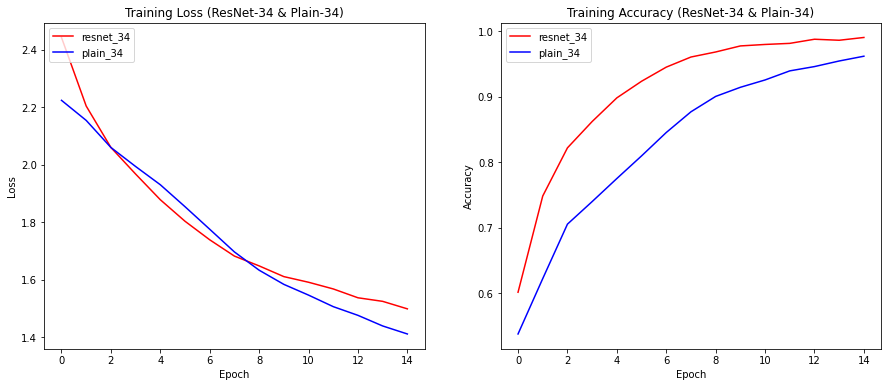

In [28]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Training Loss (ResNet-34 & Plain-34)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

# ResNet-34, Plain-34 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_plain_34.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-34 & Plain-34)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.show()

- ResNet-50, Plain-50
    - Training Loss
    - Training Accuracy

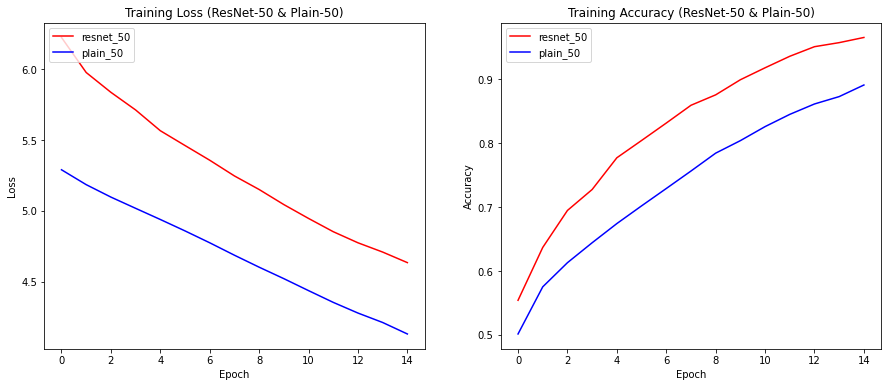

In [29]:
plt.subplots(figsize=(15,6))

# ResNet-50, Plain-50 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Training Loss (ResNet-50 & Plain-50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

# ResNet-50, Plain-50 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_50.history['accuracy'], 'r')
plt.plot(history_plain_50.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-50 & Plain-50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.show()

- ResNet-34, Plain-34, ResNet-50, Plain-50
    - Training Loss
    - Training Accuracy

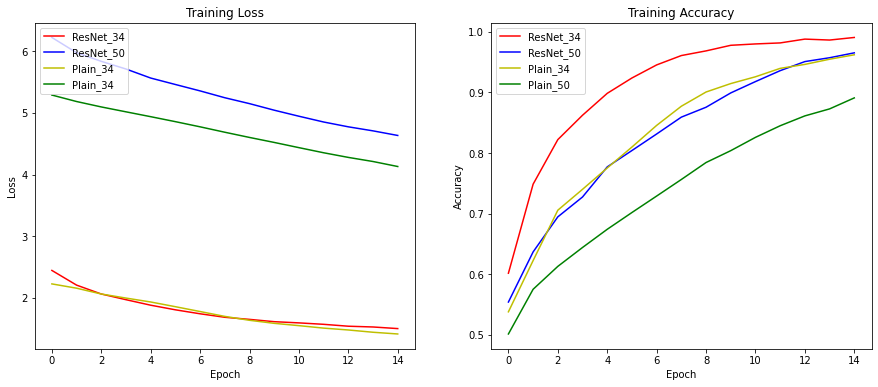

In [30]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'y')
plt.plot(history_plain_50.history['loss'], 'g')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_34'], loc='upper left')

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_resnet_50.history['accuracy'], 'b')
plt.plot(history_plain_34.history['accuracy'], 'y')
plt.plot(history_plain_50.history['accuracy'], 'g')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

plt.show()

- ResNet-34, Plain-34
    - Validation Loss
    - Validation Accuracy

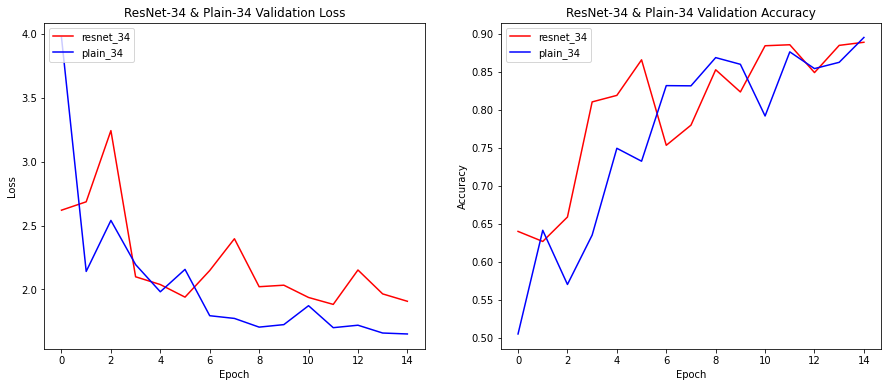

In [31]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_plain_34.history['val_loss'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

# ResNet-34, Plain-34 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.show()

- ResNet-50, Plain-50
    - Validation Loss
    - Validation Accuracy

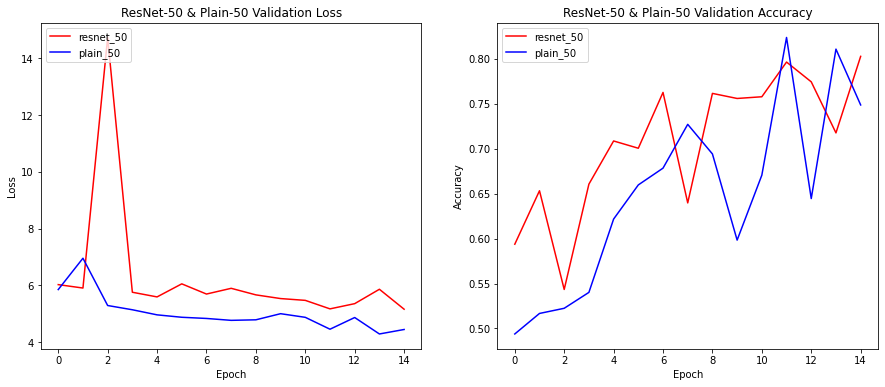

In [32]:
plt.subplots(figsize=(15,6))

# ResNet-50, Plain-50 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_50.history['val_loss'], 'r')
plt.plot(history_plain_50.history['val_loss'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

# ResNet-50, Plain-50 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.show()

- ResNet-34, Plain-34, ResNet-50, Plain-50
    - Validation Loss
    - Validation Accuracy

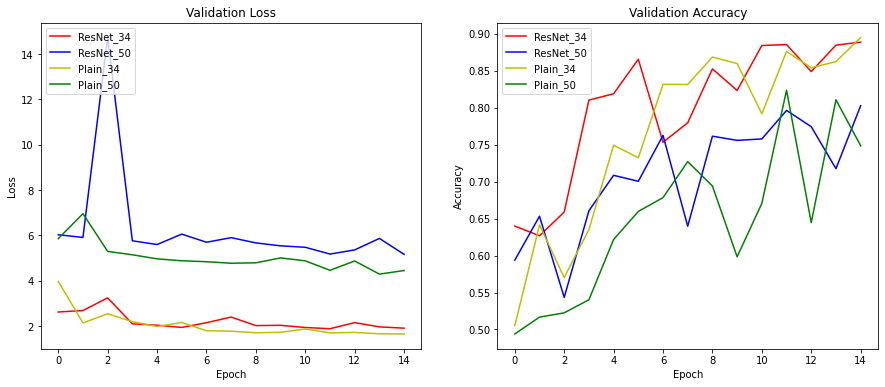

In [33]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34, ResNet-50, Plain-50 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_resnet_50.history['val_loss'], 'b')
plt.plot(history_plain_34.history['val_loss'], 'y')
plt.plot(history_plain_50.history['val_loss'], 'g')
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

# ResNet-34, Plain-34, ResNet-50, Plain-50 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'y')
plt.plot(history_plain_50.history['val_accuracy'], 'g')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

plt.show()

---

---

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
VGG 구현하는 방식을 알려줬으나 그걸 토대로 ResNet 논문을 코드로 구현하는 건 여전히 어렵다. 구글링과 펀더멘탈 22 코드를 참고할 수 밖에 없었다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- Ablation Study
- Plain
- ResNet


### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?|블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
>|2|구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.|
>|3|Ablation Study 결과가 바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|

블록 함수를 만든 다음 모델(ResNet-34, ResNet-50, Plain-34, Plain-50)을 구현하고 summary 로 확인해보았다. 구글링과 펀더멘탈 22 를 참고했다.

모든 모델의 학습은 epoch=20 으로 진행했다. 결과를 시각화해서 확인했다.


### - 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
없음

### - **자기 다짐**
계속 다시 보면서 논문 내용을 코드로 구현하는 방법을 체득해야 겠다.